# Supplementary Table 5. DROSHA processing with SRSF3
---

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2021-01-12.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
utilpath = '/casa/bsc/notebooks/'
import sys; sys.path.append(utilpath)
from util import *

In [4]:
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/210112/


In [5]:
from __future__ import division
import pandas as pd
import numpy as np
import re
import gzip
from scipy.stats import pearsonr, spearmanr
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

In [6]:
s1 = pd.read_csv('supplementary/201123_s1__DROSHA_dependency.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201123_s2__Construct.csv', header=1, index_col=0).fillna('')

In [52]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
preposition['hsa-mir-103b-1'] = (31,94)
preposition['hsa-mir-103b-2'] = (31,94)
preposition['hsa-mir-130a'] = (27,88)
preposition['hsa-mir-452'] = (29,89)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [8]:
tmp = pd.read_csv('supplementary/201012_s2_pri-construct.csv', index_col=0, header=1)
redund = tmp[tmp['Note'].apply(lambda x: str(x).find('Same construct')>=0)]
repreRedund = defaultdict(list)
for pri, note in dict(redund['Note']).items():
    repre = note.split()[-1]
    repreRedund[repre].append(pri)
print len(repreRedund)

25


In [9]:
constseqs = dict(s2['Construct sequence (125 nt)'])
print len(constseqs)

1881


In [10]:
LIBRARIES = ['cleaved_1','cleaved_2']

---
### Cleavage Efficiency

In [11]:
datapath = '../2009_srsf3_hiseq/alignments'
RCUTOFF = 30

In [12]:
#inptbl.to_csv('%s/input_counts.csv'%datapath)
inptbl = pd.read_csv('%s/input_counts.csv'%datapath,index_col=0)

In [13]:
for pri in inptbl.index:
    if pri in repreRedund:
        for pri2 in repreRedund[pri]:
            inptbl.loc[pri2] = inptbl.loc[pri]
inptbl = inptbl.sort_index()
inptbl.columns = LIBRARIES

In [14]:
#clvtbl.to_csv('%s/cleaved_count.csv'%datapath)
clvtbl = pd.read_csv('resources/210105_clvs_srsf3.csv',index_col=0)
clvtbl.head()

,Pri-miRNA,rstart,rend,cleaved_1,cleaved_2
0,hsa-let-7a-1,1,7,0.0,5.0
1,hsa-let-7a-1,1,8,0.0,3.0
2,hsa-let-7a-1,1,9,21.0,19.0
3,hsa-let-7a-1,1,10,12.0,27.0
4,hsa-let-7a-1,1,11,44.0,39.0


In [15]:
WINDOW = 3
INVERTED = 11

In [16]:
inptbl['cleaved'] = inptbl['cleaved_1']+inptbl['cleaved_2']
clvtbl['cleaved'] = clvtbl['cleaved_1']+clvtbl['cleaved_2']

In [17]:
start, mid, end = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==start)&(clvtbl['rend']<mid)].set_index('Pri-miRNA')
clv3f = clvtbl[(clvtbl['rstart']>mid)&(clvtbl['rend']==end)].set_index('Pri-miRNA')
clvhn = clvtbl[(clvtbl['rstart']<mid)&(clvtbl['rend']>mid)]
clvn5 = clvhn[clvhn['rstart']==start]
clvn3 = clvhn[clvhn['rend']==end]
clvh = clvhn.drop(clvn5.index).drop(clvn3.index).set_index('Pri-miRNA')
clvn5 = clvn5.set_index('Pri-miRNA'); clvn3 = clvn3.set_index('Pri-miRNA')

In [18]:
def fill_unfound(tbl):
    found = set(tbl.index)
    unfound = [ mir for mir in s2.index if mir not in found ]
    fill = pd.DataFrame(index=unfound, columns=tbl.columns).fillna(0)
    return tbl.append(fill)

In [19]:
clvtbl = fill_unfound(clvtbl.set_index('Pri-miRNA'))
clv5f = fill_unfound(clv5f)
clv3f = fill_unfound(clv3f)
clvh = fill_unfound(clvh)
clvn5 = fill_unfound(clvn5)
clvn3 = fill_unfound(clvn3)

In [20]:
def get_clv_cnts(mir, lib):
    ps, pe = preposition[mir]
    invs = ps+INVERTED
    inve = pe-INVERTED
    clv5 = clv5f.loc[[mir]].reset_index().set_index('rend')[lib]
    clv3 = clv3f.loc[[mir]].reset_index().set_index('rstart')[lib]
    prod5 = clv5.reindex(range(ps-1-WINDOW,ps+WINDOW)).sum()
    prod3 = clv3.reindex(range(pe+1-WINDOW,pe+2+WINDOW)).sum()
    inv5 = clv5.reindex(range(invs-1-WINDOW,invs+WINDOW)).sum()
    inv3 = clv3.reindex(range(inve+1-WINDOW,inve+2+WINDOW)).sum()
    #print prod5, prod3, inv5, inv3
    return int((prod5+prod3)/2)-int((inv5+inv3)/2)

In [147]:
inptbl.loc['hsa-mir-3166']

cleaved_1    51
cleaved_2    24
cleaved      75
Name: hsa-mir-3166, dtype: int64

In [148]:
clvcnts = pd.DataFrame()
mirs = [ m for m in inptbl[inptbl['cleaved']>=RCUTOFF].index if preposition[m][0]>0 ]
for lib in LIBRARIES+['cleaved']:
    for mir in mirs:
        clvcnts.loc[mir,lib] = get_clv_cnts(mir,lib)
clvcnts.head()

,cleaved_1,cleaved_2,cleaved
hsa-let-7a-1,44422.0,35809.0,80231.0
hsa-let-7a-2,81110.0,59840.0,140949.0
hsa-let-7a-3,16567.0,17808.0,34376.0
hsa-let-7b,82021.0,49331.0,131352.0
hsa-let-7c,19380.0,16741.0,36120.0


In [149]:
clvcnts.loc['hsa-mir-3166']

cleaved_1    16.0
cleaved_2    15.0
cleaved      32.0
Name: hsa-mir-3166, dtype: float64

In [210]:
# def calculate_norm(mir,lib):
#     clv5 = clv5f.loc[[mir]].reset_index().set_index('rend')[lib]
#     clv5 = clv5.reindex([24,30,31,42,44]).sum()
#     inp = inptbl[lib][mir]
#     return clv5/inp

In [150]:
## norm
norm = 'hsa-mir-6838'# 'hsa-mir-6788'
norms = clv5f.loc[norm,LIBRARIES+['cleaved']].sum()/inptbl.loc[norm,LIBRARIES+['cleaved']]
#norms = { lib:calculate_norm(norm, lib) for lib in LIBRARIES }
norms

cleaved_1    0.046492
cleaved_2    0.063544
cleaved      0.055240
dtype: float64

In [151]:
def calculate_efficiency(mir,lib,norms):
    clv = clvcnts.loc[mir,lib]
    inp = inptbl.loc[mir,lib]
    return np.log2(max(clv,0)/inp/norms[lib]+1)

In [24]:
r1,r2 = LIBRARIES
ms = clvcnts[[r1,r2]].dropna().index
effreps = [ (calculate_efficiency(m,r1,norms),calculate_efficiency(m,r2,norms))
                     for m in ms ]
print len(effreps)

1802


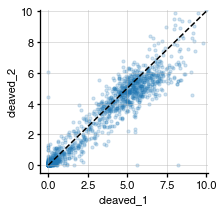

In [25]:
fig,ax = plt.subplots(1, 1, figsize=(3,3))
xs, ys = zip(*effreps)
ax.scatter(xs,ys,s=10,color='tab:blue',alpha=.2)
ax.set_xlabel(r1); ax.set_ylabel(r2)
ax.plot([0,10],[0,10],'k--')
ax.set_xlim(-.5,10.1)
ax.set_ylim(-.5,10.1)
ax.grid(ls='-')
#fig.savefig(resultpath + '210111_repro_srsf3.png',dpi=300)

In [152]:
effs = {}
suffs = [ m for m in inptbl[inptbl['cleaved']>=RCUTOFF].index if preposition[m][0]>0 ]
for mir in suffs:
    effs[mir] = calculate_efficiency(mir,'cleaved_2',norms)
print len(effs), effs['hsa-mir-144']

1812 6.249484246748845


---
### Cleavage Homogeneity

In [29]:
RCUTOFF = 30
RCUTOFFH = 10
FCUTOFF = .01
WINDOW = 3
INVERTED = 11

In [30]:
def get_frac_5frag(mir):
    sub = clv5f.loc[[mir]].set_index('rend')
    return (sub/sub.sum())

In [31]:
def get_frac_3frag(mir):
    sub = clv3f.loc[[mir]].set_index('rstart')
    return (sub/sub.sum())

In [32]:
def get_frac_hairpin(mir):
    sub = clvh.loc[[mir]].set_index(['rstart','rend'])
    return (sub/sub.sum())

In [33]:
def filter_frac(frac):
    return frac[frac>=FCUTOFF]

In [34]:
def add_specificity(row):
    row['score'] = (row['5frag']+row['hairpin']+row['3frag'])/3
    return row

In [35]:
def drop_duplicates(sortedtbl):
    if len(sortedtbl)<=1:
        return sortedtbl
    hs = sortedtbl['hstart'].tolist()[0]
    he = sortedtbl['hend'].tolist()[0]
    sub = sortedtbl.iloc[1:]
    sub = sub[(sub['hstart']!=hs)&(sub['hend']!=he)]
    return sortedtbl.iloc[:1].append(drop_duplicates(sub))

In [36]:
frac5f = { mir:get_frac_5frag(mir) for mir in s2.index } 
frac3f = { mir:get_frac_3frag(mir) for mir in s2.index } 
frachpn = { mir:get_frac_hairpin(mir) for mir in s2.index }

In [74]:
COLS = 'miRNA pstart pend hstart hend 5frag 3frag hairpin score diff5 diff3'.split()

In [112]:
def get_dcs(mir, lib):
    ps, pe = preposition[mir]
    null = pd.DataFrame({0:dict(zip(COLS,[mir,ps,pe,1,125,0,0,0,0,99,99]))}).T[COLS]
    cs = null
    sum5f = clv5f.loc[mir,lib].sum()
    sum3f = clv3f.loc[mir,lib].sum()
    sumh = clvh.loc[mir,lib].sum()
    if not (sum5f>=RCUTOFF and sum3f>=RCUTOFF and sumh>=RCUTOFFH):
        return null
    
    clv5, clv3, clvhpn = [ f[mir][lib] for f in [frac5f,frac3f,frachpn] ]
    clv52 = defaultdict(float); clv52.update(clv5)
    clv32 = defaultdict(float); clv32.update(clv3)
    clvhpn2 = defaultdict(float); clvhpn2.update(clvhpn)
    for c5, frac5 in filter_frac(clv5).items():
        for c3, frac3 in filter_frac(clv3).items():
            row = dict(zip(COLS,[mir,ps,pe,c5+1,c3-1,frac5,frac3,clvhpn2[(c5+1,c3-1)]]))
            cs = cs.append(row, ignore_index=True)
    for (c5,c3), frach in filter_frac(clvhpn).items():
        row = dict(zip(COLS,[mir,ps,pe,c5,c3,clv52[c5-1],clv32[c3+1],frach]))
        cs = cs.append(row, ignore_index=True)
    cs['score'] = (cs['5frag']+cs['hairpin']+cs['3frag'])/3
    cs['diff5'] = cs['hstart']-cs['pstart']
    cs['diff3'] = cs['pend']-cs['hend']
    cs = cs[(abs(cs['diff5'])<=WINDOW)&(abs(cs['diff3'])<=WINDOW)]
    if len(cs)>=1:
        return drop_duplicates(cs.sort_values('score').iloc[::-1])
    return null

In [124]:
mir = 'hsa-mir-452'
get_dcs(mir, 'cleaved_2')

,miRNA,pstart,pend,hstart,hend,5frag,3frag,hairpin,score,diff5,diff3
27,hsa-mir-452,29,89,29,89,0.744123,0.879988,0.398385,0.674165,0,0
17,hsa-mir-452,29,89,28,90,0.100354,0.0117689,0.000602195,0.0375752,-1,-1


In [126]:
print time.ctime()
clvall = pd.DataFrame(columns=COLS)
for mir in suffs:
    clvall = clvall.append(get_dcs(mir, 'cleaved_2'), ignore_index=True)
clvall = clvall[COLS]
print time.ctime()
print '# of all sites:\t%s' % len(clvall)
print '# of miRNAs:\t%s' % len(set(clvall['miRNA']))

Tue Jan 12 08:48:36 2021
Tue Jan 12 09:15:45 2021
# of all sites:	4311
# of miRNAs:	1812


In [127]:
clvall.to_csv('resources/210111_cleavage_sites_srsf3.csv')
#clvall = pd.read_csv('resources/210105_cleavage_sites_srsf3.csv',index_col=0)

In [114]:
#clvall = clvall.drop(clvall[clvall['miRNA']=='hsa-mir-452'].index)
#clvall = clvall.append(get_dcs('hsa-mir-452','cleaved'),ignore_index=True)

In [128]:
tmp = clvall.sort_values('score').drop_duplicates('miRNA',keep='last')
homs = tmp.set_index('miRNA')['score'].to_dict()

---

In [165]:
clvall[clvall['miRNA']=='hsa-mir-6808']

,miRNA,pstart,pend,hstart,hend,5frag,3frag,hairpin,score,diff5,diff3
3759,hsa-mir-6808,35,88,34,91,0.00628931,0.13667,0.0123762,0.0517785,-1,-3


In [129]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
droko = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA KO')>=0)].index
fclip = s1[s1['DROSHA dependency'].apply(lambda x:x.find('fCLIP')>=0)].index
dbmirs = s1[s1['MirGeneDB']=='Annotated'].index
print len(drodep), len(droind), len(droko), len(fclip)

304 257 157 281


In [130]:
overlap = [m for m in effs if m in homs ]
mirls = [ [m for m in overlap if m in drodep], 
          [m for m in overlap if m in droind],
          [m for m in overlap if m not in list(drodep)+list(droind)] ]
xsl = [ [effs[m] for m in ml] for ml in mirls ]
ysl = [ [homs[m] for m in ml] for ml in mirls ]
fcolors = [ '#1b9e77', '#666666', '#cbcbcb' ]
ecolors = [ '#018571', '#353535','#bababa' ]
labels = [ 'DRO-dep.', 'DRO-ind.', 'The rest' ]
sizes = [ 10, 10, 6 ]
zs = [ 4, 3, 2 ]
xmin, xmax, xo = 0, 8, .2
ymin, ymax, yo = 0, 1, .03
xcut, ycut = 1.5, .25
shade = '#a1d99b'
print map(len,mirls)

[296, 254, 1262]


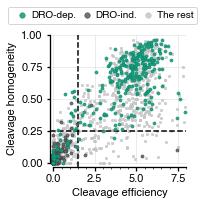

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
for xs,ys,fc,ec,label,s,z in zip(xsl,ysl,fcolors,ecolors,labels,sizes,zs):
    xs,ys = zip(*[ (x,y) for x,y in zip(xs,ys) if xmin<=x<xmax and ymin<=y<ymax])
    ax.scatter(xs, ys, s=s, color=fc, edgecolor=ec, lw=.5, zorder=z, label=label, alpha=.9,
              rasterized=True)
ax.plot([xmin-xo,xmax],[ycut,ycut],'k--',zorder=2)
ax.plot([xcut,xcut],[ymin-yo,ymax],'k--',zorder=2)

ax.set_xlabel('Cleavage efficiency',fontsize=11)
ax.set_ylabel('Cleavage homogeneity',fontsize=11)
ax.set_xticks(np.arange(xmin,xmax+xo,.5),minor=True)
ax.set_yticks(np.arange(ymin,ymax+yo,.25))
ax.set_xlim(xmin-xo, xmax+xo)
ax.set_ylim(ymin-yo, ymax+yo)
ax.spines['bottom'].set_bounds(xmin, xmax)
ax.spines['left'].set_bounds(ymin, ymax)
leg = ax.legend(loc=(-.3,1.05), handletextpad=-.1, ncol=3, columnspacing=.05)
for handle in leg.legendHandles:
    handle.set_sizes([30])

gr = plt.Rectangle((xmin-xo/4,ymin-yo/4), xmax+xo/4, ymax+yo/4, fc='w'); ax.add_patch(gr)
ax.grid(ls='-', lw=.5, clip_path=gr)
#fig.savefig(resultpath + '210105_f2b__cleavage_pattern.pdf',dpi=300)

In [ ]:
mirtrons = s1[s1['DROSHA dependency'].apply(lambda x:x.find('Mirtron')>=0)].index
mirls = [ [m for m in overlap if m in mirtrons], 
          [m for m in overlap if m not in mirtrons] ]
xsl = [ [effs[m] for m in ml] for ml in mirls ]
ysl = [ [homs[m] for m in ml] for ml in mirls ]
fcolors = [ '#dfc27d', '#cbcbcb' ]
ecolors = [ '#a6611a','#bababa' ]
labels = [ 'Mirtrons (%s)'%len(mirls[0]), 'The rest (%s)'%len(mirls[1]) ]
sizes = [ 12, 5 ]
zs = [ 3,2 ]
xmin, xmax, xo = 0, 8, .15
ymin, ymax, yo = 0, 1, .03
xcut, ycut = 1.5, .25
shade = '#a1d99b'
print map(len,mirls)

---
### Build table

In [132]:
homcut = .25
clvsig = clvall[clvall['score']>=homcut]
clvcnt = Counter(clvsig['miRNA'])

In [155]:
effcut = 1.5
dcsmirs = [ m for m in overlap if effs[m]>=effcut and homs[m]>=homcut ]
single = [ m for m in overlap if effs[m]>=effcut and clvcnt[m]==1 ]
alternative = [ m for m in overlap if effs[m]>=effcut and clvcnt[m]>=2 ]
print len(dcsmirs), len(single), len(alternative)

747 690 57


In [156]:
cols = [ 'Pri-miRNA', 'Cleavage Efficiency', 'Cleavage Homogeneity',
         "5' miRBase site", "3' miRBase site", "5' cleavage site", "3' cleavage site", 
         "5' alternative site", "3' alternative site", "Cleavage ratio of alternative site",
         '5p nick processing', '3p nick processing', 'Inverted processing' ]
tbl = pd.DataFrame(columns=cols).set_index('Pri-miRNA')
tbl.head(1)

,Cleavage Efficiency,Cleavage Homogeneity,5' miRBase site,3' miRBase site,5' cleavage site,3' cleavage site,5' alternative site,3' alternative site,Cleavage ratio of alternative site,5p nick processing,3p nick processing,Inverted processing
Pri-miRNA,,,,,,,,,,,,


In [157]:
for pri in overlap:
    ps, pe = preposition[pri]
    tbl.loc[pri,'Cleavage Efficiency'] = effs[pri]
    tbl.loc[pri,'Cleavage Homogeneity'] = homs[pri]
    tbl.loc[pri,"5' miRBase site"] = ps
    tbl.loc[pri,"3' miRBase site"] = pe
    sub = clvall[clvall['miRNA']==pri].sort_values('score',ascending=False)
    sub = sub[sub['score']>0]
    if len(sub)>=1:
        tbl.loc[pri,"5' cleavage site"] = sub['hstart'].values[0]
        tbl.loc[pri,"3' cleavage site"] = sub['hend'].values[0]
        if len(sub)>=2:
            tbl.loc[pri,"5' alternative site"] = sub['hstart'].values[1]
            tbl.loc[pri,"3' alternative site"] = sub['hend'].values[1]
            tbl.loc[pri,"Cleavage ratio of alternative site"] = sub['score'].values[1]

In [158]:
for mir in overlap:
    ps, pe = preposition[mir]
    if ps<1 or pe>125:
        continue
    unc5 = clvn5.loc[[mir]].reset_index().set_index(['rend'])
    unc5 = unc5.reindex(range(pe-WINDOW,pe+WINDOW+1)).sum()
    unc3 = clvn3.loc[[mir]].reset_index().set_index(['rstart'])
    unc3 = unc3.reindex(range(ps-WINDOW,ps+WINDOW+1)).sum()
    hpn = clvh.loc[[mir]]
    prohpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                  (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()
    invhpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps+INVERTED-WINDOW,
                                                           ps+INVERTED+WINDOW+1)) and 
                                     (x['rend'] in range(pe-INVERTED-WINDOW,
                                                         pe-INVERTED+WINDOW+1)),axis=1)].sum()
    lib = 'cleaved_2'
    if prohpn[lib].sum()>=RCUTOFFH:
        tbl.loc[mir,'5p nick processing'] = (unc3[lib]+1)/(prohpn[lib]+1)
        tbl.loc[mir,'3p nick processing'] = (unc5[lib]+1)/(prohpn[lib]+1)
        tbl.loc[mir,'Inverted processing'] = (invhpn[lib]+1)/(prohpn[lib]+1)

In [159]:
tbl.head()

,Cleavage Efficiency,Cleavage Homogeneity,5' miRBase site,3' miRBase site,5' cleavage site,3' cleavage site,5' alternative site,3' alternative site,Cleavage ratio of alternative site,5p nick processing,3p nick processing,Inverted processing
Pri-miRNA,,,,,,,,,,,,
hsa-mir-7-3,6.21048,0.958786,31,90,31,90,NaN,NaN,NaN,0.00875789,0.000589474,8.42105e-05
hsa-mir-770,0.290522,0.100317,30,91,30,91,28,94,0.0269999,1.65,1.2,16.4
hsa-mir-6891,0,0,18,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hsa-mir-6890,1.14974,0.21625,34,89,31,92,34,91,0.0293871,NaN,NaN,NaN
hsa-mir-6893,0,0.0662903,30,93,31,90,29,91,0.0515133,NaN,NaN,NaN


In [160]:
tbl.to_csv('resources/210111_s7__DROSHA_processing_with_SRSF3.csv')

In [161]:
out = open('supplementary/210111_s7__DROSHA_processing_with_SRSF3.csv', 'wt')
description = 'Supplementary Table 7. DROSHA processing with SRSF3\n\n\n\n\n'
out.write(description)
for l in open('resources/210111_s7__DROSHA_processing_with_SRSF3.csv', 'rt'):
    out.write(l)
out.close()

In [130]:
out = open('resources/eff_tmp_srsf3.txt','wt')
for m in effs:
    out.write('%s\t%s\n'%(m,effs[m]))
out.close()

In [121]:
def get_dcs_sub(mir, lib):
    ps, pe = preposition[mir]
    null = pd.DataFrame({0:dict(zip(COLS,[mir,ps,pe,1,125,0,0,0,0,99,99]))}).T[COLS]
    cs = null
    sum5f = clv5f.loc[mir,lib].sum()
    sum3f = clv3f.loc[mir,lib].sum()
    sumh = clvh.loc[mir,lib].sum()
    if not (sum5f>=RCUTOFF and sum3f>=RCUTOFF and sumh>=RCUTOFFH):
        return null
    
    clv5, clv3, clvhpn = [ f[mir][lib] for f in [frac5f,frac3f,frachpn] ]
    clv52 = defaultdict(float); clv52.update(clv5)
    clv32 = defaultdict(float); clv32.update(clv3)
    clvhpn2 = defaultdict(float); clvhpn2.update(clvhpn)
    for c5, frac5 in filter_frac(clv5).items():
        for c3, frac3 in filter_frac(clv3).items():
            row = dict(zip(COLS,[mir,ps,pe,c5+1,c3-1,frac5,frac3,clvhpn2[(c5+1,c3-1)]]))
            cs = cs.append(row, ignore_index=True)
    for (c5,c3), frach in filter_frac(clvhpn).items():
        row = dict(zip(COLS,[mir,ps,pe,c5,c3,clv52[c5-1],clv32[c3+1],frach]))
        cs = cs.append(row, ignore_index=True)
    cs['score'] = (cs['5frag']+cs['hairpin']+cs['3frag'])/3
    cs['diff5'] = cs['hstart']-cs['pstart']
    cs['diff3'] = cs['pend']-cs['hend']
    cs = cs[(abs(cs['diff5'])<=WINDOW)&(abs(cs['diff3'])<=WINDOW)]
    return drop_duplicates(cs.sort_values('score').iloc[::-1])

In [123]:
mir = 'hsa-mir-214'
get_dcs_sub(mir, 'cleaved_2')

,miRNA,pstart,pend,hstart,hend,5frag,3frag,hairpin,score,diff5,diff3
87,hsa-mir-214,30,92,28,91,0.0649944,0.0329802,0,0.0326582,-2,1
102,hsa-mir-214,30,92,31,94,0.0285366,0.0168632,0,0.0151333,1,-2


In [108]:
clvcnts['hsa-mir-3179-1']

(111151.0, 13471.0)

In [102]:
m = 'hsa-mir-3179-4'
inptbl.loc[m,'input']

56136

In [110]:
clvcnts['hsa-mir-214']

(1095.0, 3739.0)

In [111]:
preposition['hsa-mir-214']

(30, 92)